### Note

Repository
https://github.com/Wikar235/disease-recognition

Project
https://github.com/users/Wikar235/projects/2

Data
https://www.kaggle.com/datasets/lokisilvres/dental-disease-panoramic-detection-dataset

### Load Data

#### Image download

In [48]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lokisilvres/dental-disease-panoramic-detection-dataset")

In [49]:
!tree $path -d

/Users/syatsuzuka/.cache/kagglehub/datasets/lokisilvres/dental-disease-panoramic-detection-dataset/versions/6
├── COCO
│   └── COCO
│       ├── annotations
│       ├── test
│       ├── train
│       └── valid
└── YOLO
    └── YOLO
        ├── test
        │   ├── images
        │   └── labels
        ├── train
        │   ├── images
        │   └── labels
        └── valid
            ├── images
            └── labels

18 directories


#### Listing up image files

##### Training data

In [50]:
import os
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw

image_extensions = ['.jpg', '.jpeg', '.png', '.tiff', '.bmp']
count_train = 0
files_train = []
files_train_labels = []

for root, dirs, files in os.walk(path+"/YOLO/YOLO/train"):
    for file in files:
        if any(file.lower().endswith(ext) for ext in image_extensions):
            count_train += 1
            files_train.append(os.path.join(root, file))
            files_train_labels.append(os.path.join(root.replace('/images', '/labels'), os.path.splitext(file)[0] + '.txt'))

##### Test data

In [51]:
count_test = 0
files_test = []
files_test_labels = []

for root, dirs, files in os.walk(path+"/YOLO/YOLO/test"):
    for file in files:
        if any(file.lower().endswith(ext) for ext in image_extensions):
            count_test += 1
            files_test.append(os.path.join(root, file))
            files_test_labels.append(os.path.join(root.replace('/images', '/labels'), os.path.splitext(file)[0] + '.txt'))

##### Validation data

In [52]:
count_valid = 0
files_valid = []
files_valid_labels = []

for root, dirs, files in os.walk(path+"/YOLO/YOLO/valid"):
    for file in files:
        if any(file.lower().endswith(ext) for ext in image_extensions):
            count_valid += 1
            files_valid.append(os.path.join(root, file))
            files_valid_labels.append(os.path.join(root.replace('/images', '/labels'), os.path.splitext(file)[0] + '.txt'))

#### Sample Image check

0 /Users/syatsuzuka/.cache/kagglehub/datasets/lokisilvres/dental-disease-panoramic-detection-dataset/versions/6/YOLO/YOLO/train/images/3585150000-jpg_png_jpg.rf.45c5a7e150f53076399c33479c775ab8.jpg
Image shape: (640, 640, 3)
Image data type: uint8
Min pixel value: 0
Max pixel value: 255
1 /Users/syatsuzuka/.cache/kagglehub/datasets/lokisilvres/dental-disease-panoramic-detection-dataset/versions/6/YOLO/YOLO/train/images/3832840000-jpg_png_jpg.rf.917a84a8314fc4b44f3ffec2be024915.jpg
Image shape: (840, 1615, 3)
Image data type: uint8
Min pixel value: 0
Max pixel value: 255
2 /Users/syatsuzuka/.cache/kagglehub/datasets/lokisilvres/dental-disease-panoramic-detection-dataset/versions/6/YOLO/YOLO/train/images/9ca39105-MORTAJI_SAEIDEH_2020-06-16104607_jpg.rf.c7fed91c49456945ae346784f51b2e16.jpg
Image shape: (840, 1615, 3)
Image data type: uint8
Min pixel value: 0
Max pixel value: 255
3 /Users/syatsuzuka/.cache/kagglehub/datasets/lokisilvres/dental-disease-panoramic-detection-dataset/versions/6

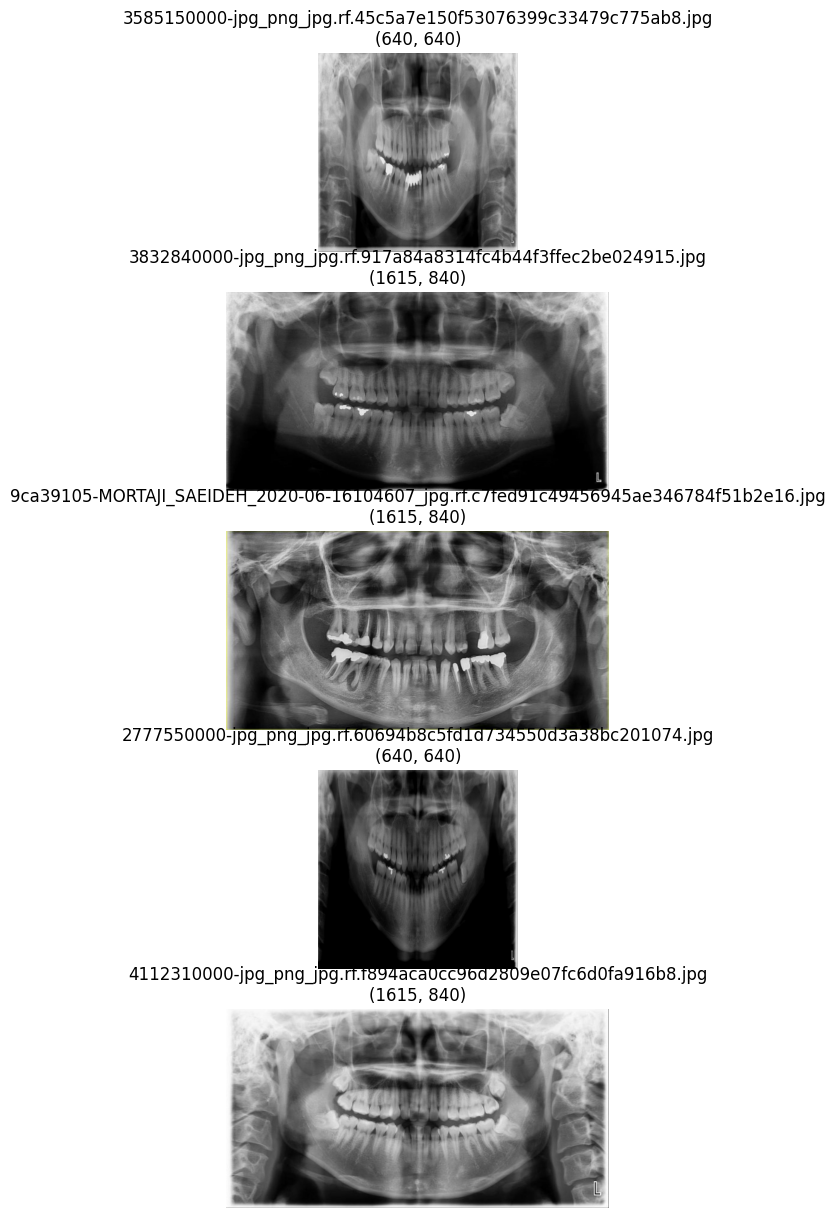

In [53]:
plt.figure(figsize=(20, 15))
img = []

for i, img_file in enumerate(files_train):
    if (i >= 5):
        break

    print(i, img_file)
    img.append(Image.open(os.path.join(root, img_file)))
    numpy_array_pil = np.array(img[i])

    print("Image shape:", numpy_array_pil.shape)
    print("Image data type:", numpy_array_pil.dtype)
    print("Min pixel value:", numpy_array_pil.min())
    print("Max pixel value:", numpy_array_pil.max())

    plt.subplot(5, 1, i+1)
    plt.imshow(img[i], cmap='gray' if img[i].mode == 'L' else None)
    plt.title(f"{os.path.basename(img_file)}\n{img[i].size}")
    plt.axis('off')

##### Loading training data

In [54]:
X_train = []

for i, img_file in enumerate(files_train):
    img = Image.open(os.path.join(root, img_file))
    X_train.append(np.array(img))


##### Loading test data

In [55]:
X_test = []

for i, img_file in enumerate(files_test):
    img = Image.open(os.path.join(root, img_file))
    X_test.append(np.array(img))

Loading validation data

In [56]:
X_valid = []

for i, img_file in enumerate(files_valid):
    img = Image.open(os.path.join(root, img_file))
    X_valid.append(np.array(img))

### Read labels

In [57]:
def read_coco_labels(label_file, img_width, img_height):

    labels = []

    if os.path.exists(label_file):
        with open(label_file, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue  # skip invalid line
                class_id, x_center, y_center, w, h = map(float, parts)

                x_center_abs = x_center * img_width
                y_center_abs = y_center * img_height
                w_abs = w * img_width
                h_abs = h * img_height

                labels.append([class_id, x_center_abs, y_center_abs, w_abs, h_abs])

    return np.array(labels)

In [58]:
def read_yolo_polygon(label_file, img_width, img_height):

    polygons = []

    if os.path.exists(label_file):
        with open(label_file, "r") as f:
            for line in f:
                parts = line.strip().split()
                class_id = int(parts[0])
                coords = list(map(float, parts[1:]))
                points = [(coords[i] * img_width, coords[i+1] * img_height)
                          for i in range(0, len(coords), 2)]
                polygons.append((class_id, points))

    # print("label_file:", label_file)

    # for polygon in polygons:
    #     print("Polygon class_id:", polygon[0], ", # of points:", len(polygon[1]), ", Points:", polygon[1])

    return polygons

In [59]:
label_path = path+"/YOLO/YOLO/train/labels"

all_labels = []

for i, img_file in enumerate(files_train):
    base_name = os.path.basename(img_file)
    name_no_ext = os.path.splitext(base_name)[0]
    label_file = os.path.join(label_path, name_no_ext + '.txt')

    # Check if label file exists
    if not os.path.exists(label_file):
        all_labels.append(np.array([]))  # append empty array for this image
        continue

    # Get image size
    img_obj = Image.open(img_file)
    width, height = img_obj.size

    # Read labels
    labels = read_yolo_polygon(label_file, width, height)
    all_labels.append(labels)


#### Check a sample labels

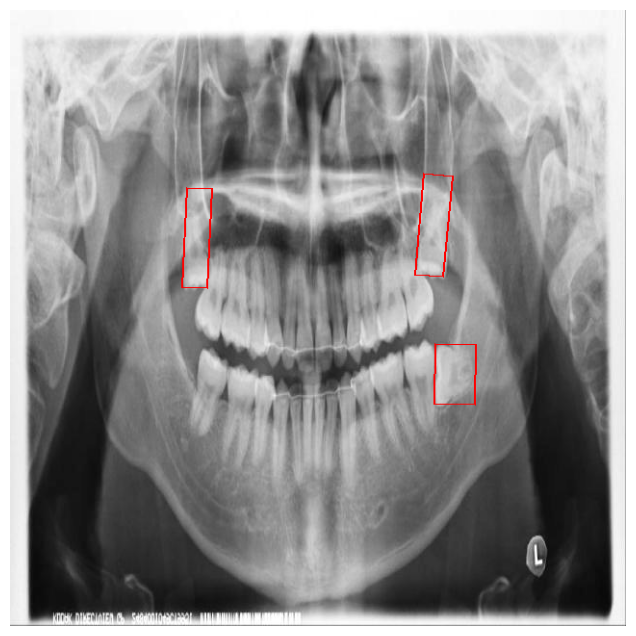

In [60]:
# Open image
index = 50

img = Image.open(files_train[index])
width, height = img.size

# Read polygons from its label
if os.path.exists(files_train_labels[index]):
    polygons = read_yolo_polygon(files_train_labels[index], width, height)
else:
    print("Label file does not exist:", files_train_labels[index])
    polygons = []

# Draw polygons
draw = ImageDraw.Draw(img)
for class_id, points in polygons:
    draw.polygon(points, outline="red", width=2)
    # for x, y in points:
    #     draw.ellipse((x-2, y-2, x+2, y+2), fill="blue")

plt.figure(figsize=(8,8))
plt.imshow(img)
plt.axis("off")
plt.show()

### Load Yolo model

In [61]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLOv8n model
pt_file = path+"/best.pt"
# pt_file = "yolo11n-seg.pt"
model = YOLO(pt_file)

# Display model information (optional)
# model.info()

# Train the model on the COCO8 example dataset for 100 epochs
# yaml_file = path + "/YOLO/YOLO/data.yaml"
# results = model.train(data=yaml_file, epochs=1, imgsz=640)

### Yolo Prediction

#### Best Model

YOLOv8x-seg summary: 243 layers, 65,255,261 parameters, 0 gradients, 298.3 GFLOPs

image 1/1 /Users/syatsuzuka/.cache/kagglehub/datasets/lokisilvres/dental-disease-panoramic-detection-dataset/versions/6/YOLO/YOLO/test/images/4089280000-jpg_png_jpg.rf.df7df8f64f726034b18a9aee518a087d.jpg: 640x640 3 Fillings, 4 impacted tooths, 435.5ms
Speed: 1.1ms preprocess, 435.5ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)


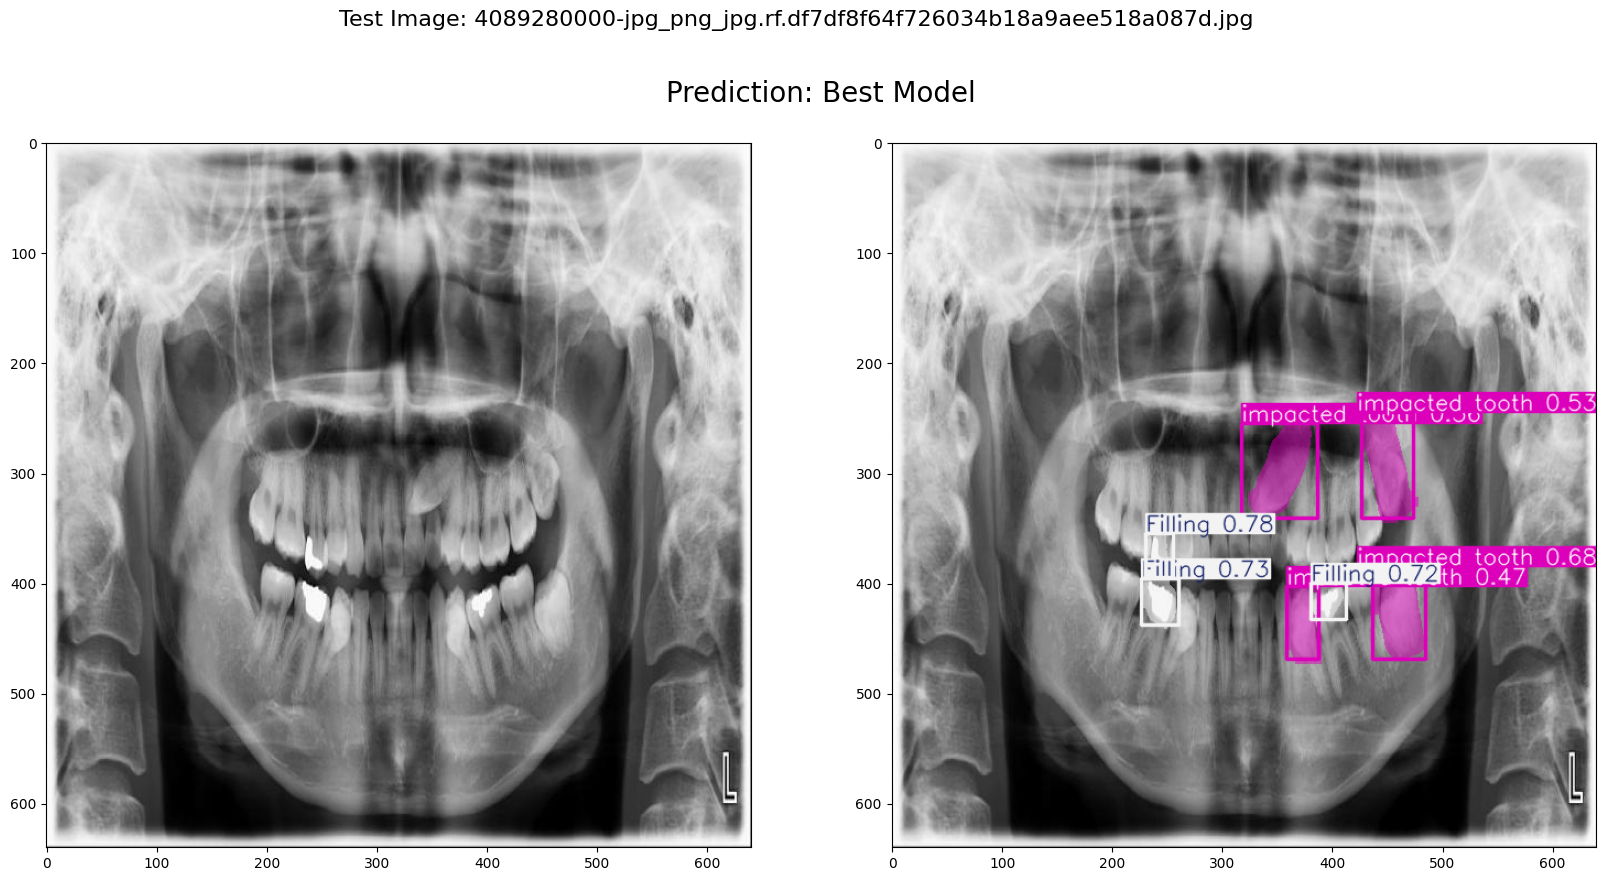

In [95]:
import multiprocessing
import torch
from ultralytics import YOLO
import cv2


#===== Choose a sample image =====
index = 210
test_image = files_test[index]

#===== Show the Test Image =====
img = Image.open(test_image)

#===== Loading a model =====
pt_file = path+"/best.pt"
# pt_file = "/Users/syatsuzuka/code/Wikar235/disease-recognition/models/trained_model.pt"
# pt_file = "/Users/syatsuzuka/code/Wikar235/disease-recognition/models/trained_model_100epoch.pt"
model = YOLO(pt_file)
model.info()

#===== Prediction =====
results = model.predict(test_image)
plotted_img = results[0].plot()

#===== Show Prediction Result =====
plt.figure(figsize=(20, 10))
plt.suptitle(f"Test Image: {os.path.basename(test_image)}", fontsize=16)
plt.title(f"Prediction: Best Model", fontsize=20)
plt.axis('off')

plt.subplot(1, 2, 1)
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(plotted_img, cv2.COLOR_BGR2RGB))

### Custom Model (5 epoch)

YOLO11n-seg summary: 203 layers, 2,848,653 parameters, 0 gradients, 9.8 GFLOPs

image 1/1 /Users/syatsuzuka/.cache/kagglehub/datasets/lokisilvres/dental-disease-panoramic-detection-dataset/versions/6/YOLO/YOLO/test/images/4089280000-jpg_png_jpg.rf.df7df8f64f726034b18a9aee518a087d.jpg: 416x416 3 Fillings, 3 impacted tooths, 37.4ms
Speed: 0.8ms preprocess, 37.4ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)


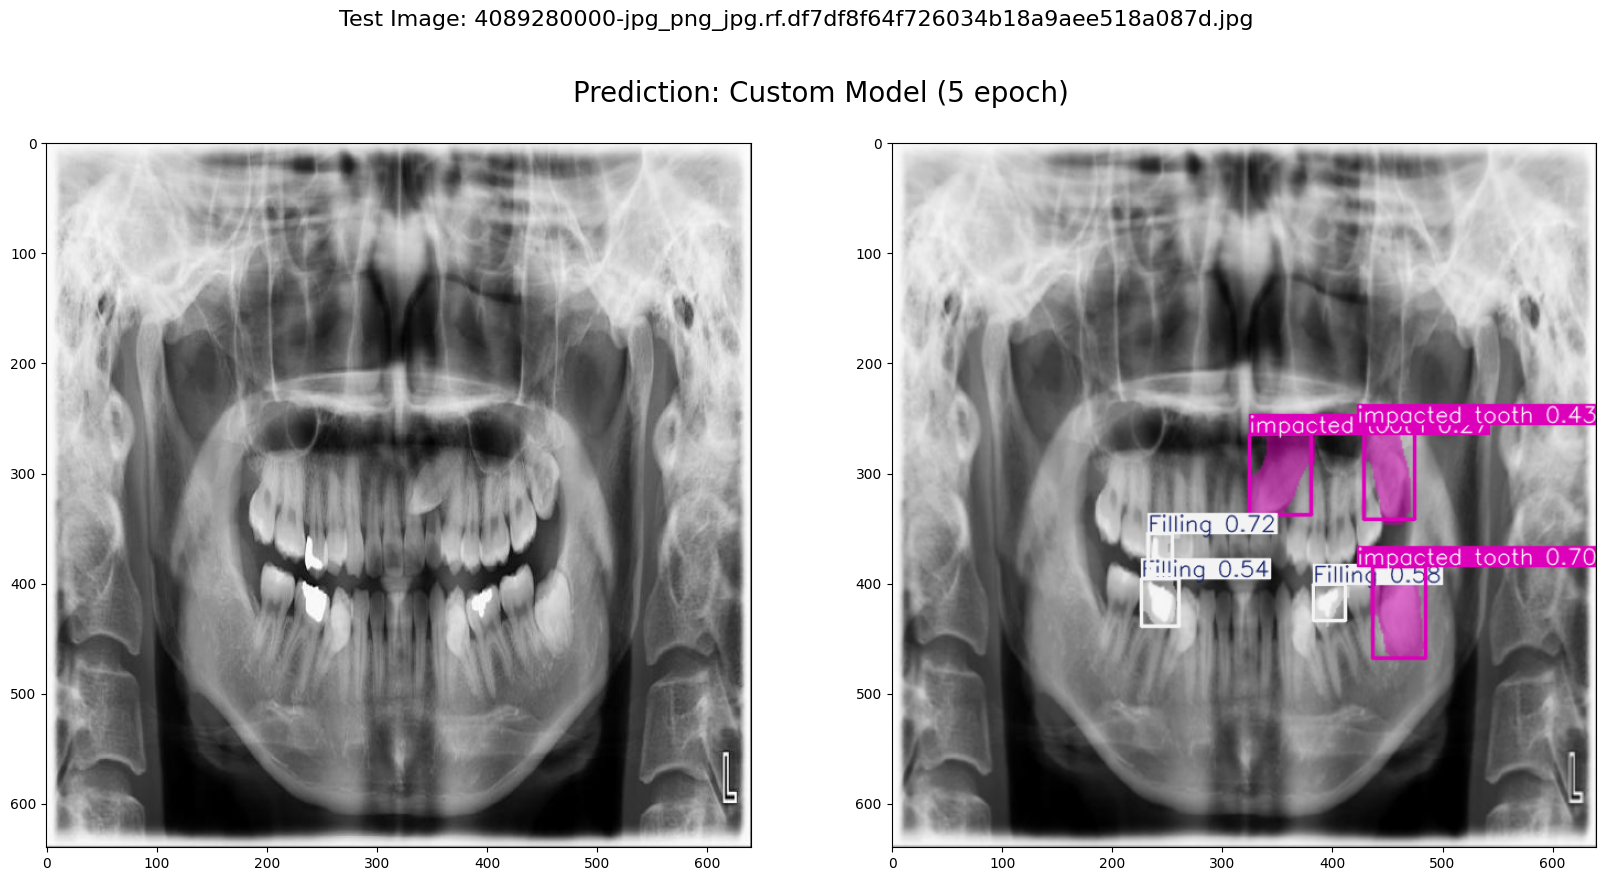

In [100]:
#===== Loading a model =====
# pt_file = path+"/best.pt"
pt_file = "/Users/syatsuzuka/code/Wikar235/disease-recognition/models/trained_model.pt"
# pt_file = "/Users/syatsuzuka/code/Wikar235/disease-recognition/models/trained_model_100epoch.pt"
model = YOLO(pt_file)
model.info()

#===== Prediction =====
results = model.predict(test_image)
plotted_img = results[0].plot()

#===== Show Prediction Result =====
plt.figure(figsize=(20, 10))
plt.suptitle(f"Test Image: {os.path.basename(test_image)}", fontsize=16)
plt.title(f"Prediction: Custom Model (5 epoch)", fontsize=20)
plt.axis('off')

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(plotted_img, cv2.COLOR_BGR2RGB))

### Custom Model (100 epoch)

YOLO11n-seg summary: 203 layers, 2,848,653 parameters, 0 gradients, 9.8 GFLOPs

image 1/1 /Users/syatsuzuka/.cache/kagglehub/datasets/lokisilvres/dental-disease-panoramic-detection-dataset/versions/6/YOLO/YOLO/test/images/4089280000-jpg_png_jpg.rf.df7df8f64f726034b18a9aee518a087d.jpg: 416x416 4 Fillings, 3 impacted tooths, 34.7ms
Speed: 0.9ms preprocess, 34.7ms inference, 2.5ms postprocess per image at shape (1, 3, 416, 416)


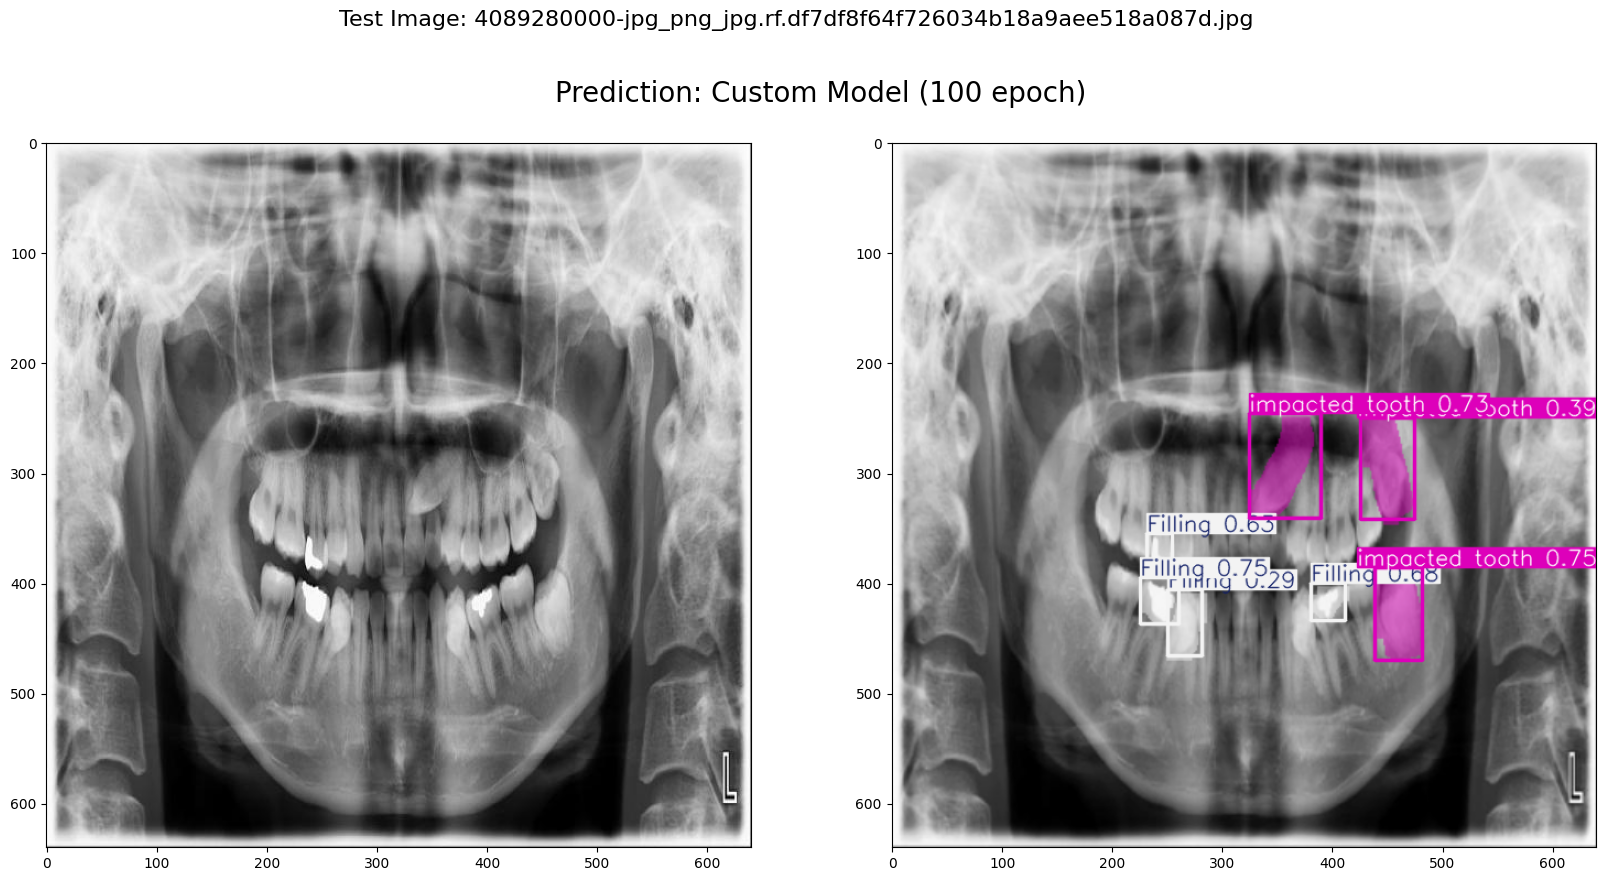

In [99]:
#===== Loading a model =====
# pt_file = path+"/best.pt"
# pt_file = "/Users/syatsuzuka/code/Wikar235/disease-recognition/models/trained_model.pt"
pt_file = "/Users/syatsuzuka/code/Wikar235/disease-recognition/models/trained_model_100epoch.pt"
model = YOLO(pt_file)
model.info()

#===== Prediction =====
results = model.predict(test_image)
plotted_img = results[0].plot()

#===== Show Prediction Result =====
plt.figure(figsize=(20, 10))
plt.suptitle(f"Test Image: {os.path.basename(test_image)}", fontsize=16)
plt.title(f"Prediction: Custom Model (100 epoch)", fontsize=20)
plt.axis('off')

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(plotted_img, cv2.COLOR_BGR2RGB))